### Topic 8: Exploratory Data Analysis (EDA)

The data for this project is a bike buyers data retrieved from kaggle. The dataset contains information from 1000 buyers and records their decision whether or not to buy a bike. Using this data we can assist the bike seller in determining features of buyers that are associated with a higher likelihood to buy a bike. Market analysis in this sector predicts the bicycle business to grow from 110.38 billion in 2023 to 228.90 billion by 2030 (Fortune Business Insights, 2023). A data scientist might be tasked with developing insights from company data that allows the business to make decisions. In a business setting, obtaining data and getting understanding of it is among the first steps in a data scientist role. Exploratory data analysis and statistical methods for validation of hypothesis are a key part in developing insights for both stakeholders and analysts. The following features are provided in the dataset:

__ID__: Customer identifier

__MaritalStatus__: Relationship status of customer

__Gender__: Sex of customer

__Income__: Annual Income of customer

__Children__: Number of children of customer

__Education__: Highest education completed by customer 

__Occupation__: Customer occupation type

__HomeOwner__: Customer home ownership status

__Cars__: Number of cars owned by customer

__CommuteDistance__: Range of miles travelled by customer

__Region__: Region (Europe, Pacific, or Northwest)

__Age__: Age of customer

__PurchasedBike__: Yes/No if customer purchased bike

##### Load packages

In [1]:
#!pip install numexpr

In [67]:
#import necessary packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.formula.api import ols
from scipy.stats import kruskal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings 
  
# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 

##### Read data investigate/clean

In [3]:
#import dataset
df = pd.read_csv('bike_buyers.csv')

In [4]:
#print dtypes of dataset
df.dtypes

ID                    int64
Marital Status       object
Gender               object
Income              float64
Children            float64
Education            object
Occupation           object
Home Owner           object
Cars                float64
Commute Distance     object
Region               object
Age                 float64
Purchased Bike       object
dtype: object

In [5]:
#rename columns for ease of coding
df = df.rename(columns={'Purchased Bike': 'PurchasedBike',
                        'Commute Distance': 'CommuteDistance',
                       'Home Owner':'HomeOwner',
                       'Marital Status':'MaritalStatus'})

In [6]:
#check if there are null values in the dataframe
df.isnull().sum()

ID                  0
MaritalStatus       7
Gender             11
Income              6
Children            8
Education           0
Occupation          0
HomeOwner           4
Cars                9
CommuteDistance     0
Region              0
Age                 8
PurchasedBike       0
dtype: int64

In [7]:
#remove null values
df = df.dropna()

The choice to drop null values rather than fill them was made tue to the low amount of null variables and that of the nulls, most are categrocal features. 

In [35]:
df['PurchasedBike'].unique()

array(['No', 'Yes'], dtype=object)

In [8]:
#print desciptive summary statistics of dataset
df.describe()

,ID,Income,Children,Cars,Age
count,952.000000,952.000000,952.000000,952.000000,952.000000
mean,19979.940126,55903.361345,1.898109,1.452731,44.256303
std,5334.000279,30845.483596,1.620426,1.111962,11.428167
min,11000.000000,10000.000000,0.000000,0.000000,25.000000
25%,15310.250000,30000.000000,0.000000,1.000000,35.000000
50%,19747.500000,60000.000000,2.000000,1.000000,43.000000
75%,24531.500000,70000.000000,3.000000,2.000000,52.000000
max,29447.000000,170000.000000,5.000000,4.000000,89.000000


##### Object distributions

In [9]:
#create barplots of categorical features in the dataframe
cols_list = list(df.select_dtypes("object").columns)

def get_count_plots(df, cols_list):
    for col in cols_list:
        plt.figure(figsize=(8, 6))
        sns.countplot(data=df, x=col)
        plt.title(f'Value Counts of {col}')
        plt.xticks(rotation=45)
        plt.show()

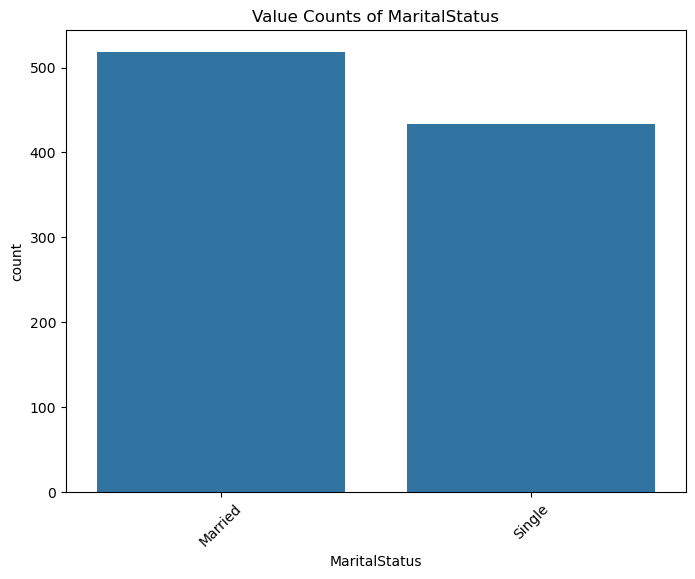

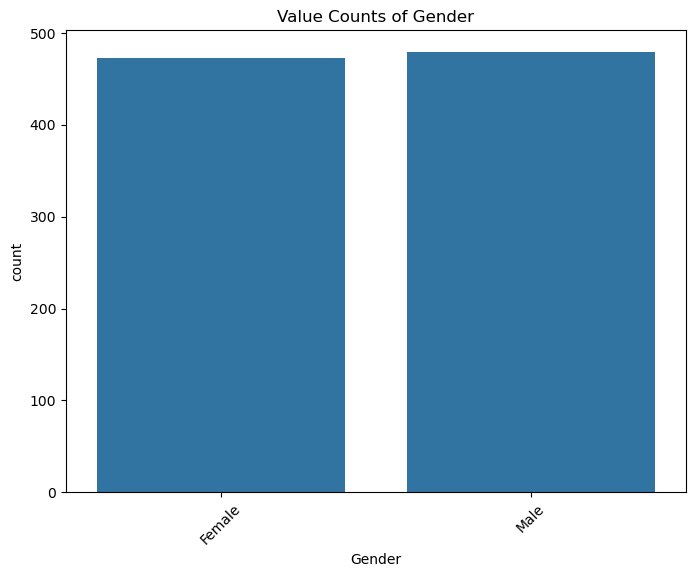

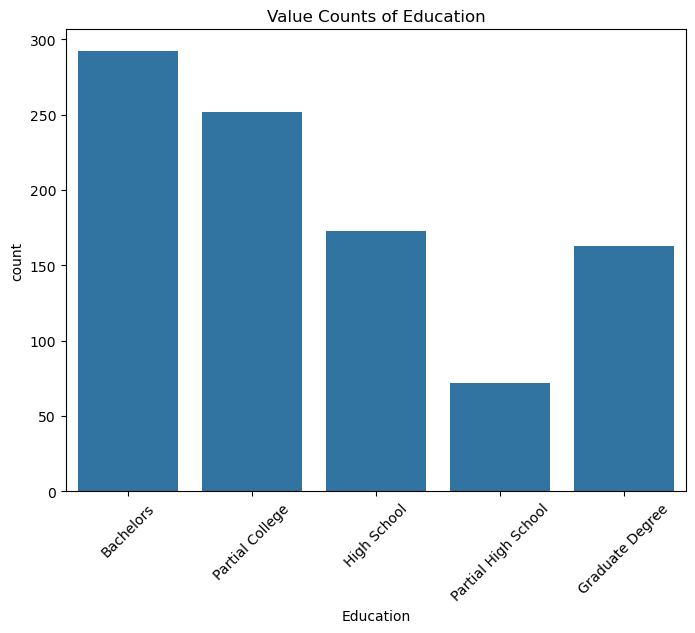

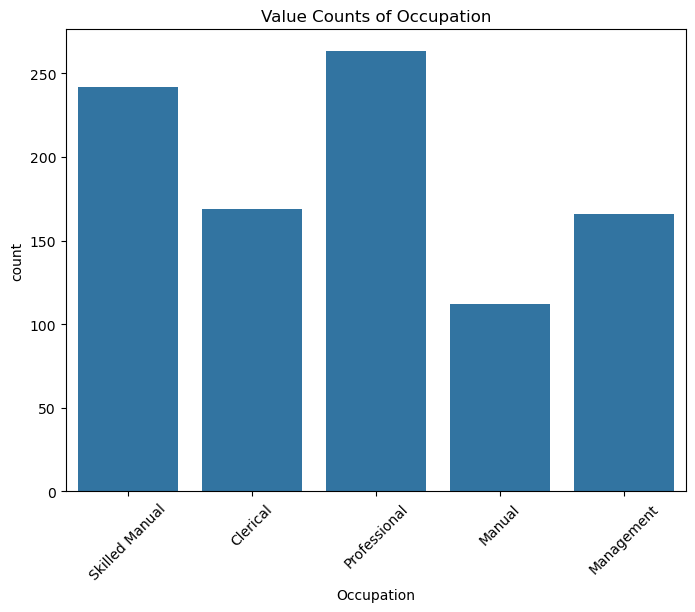

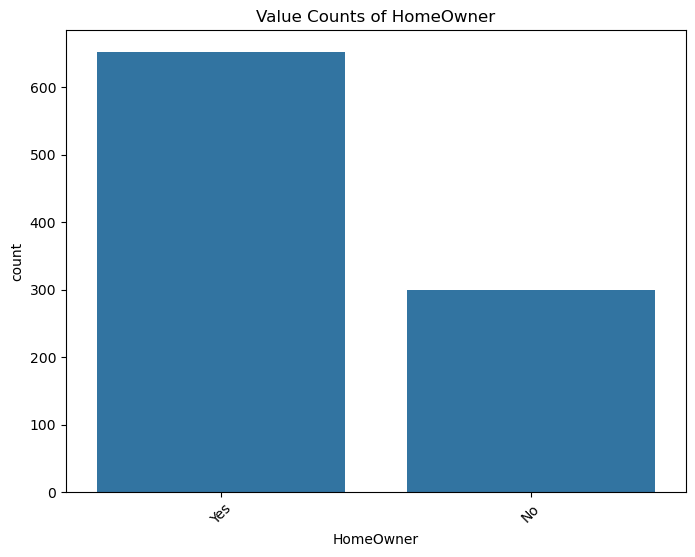

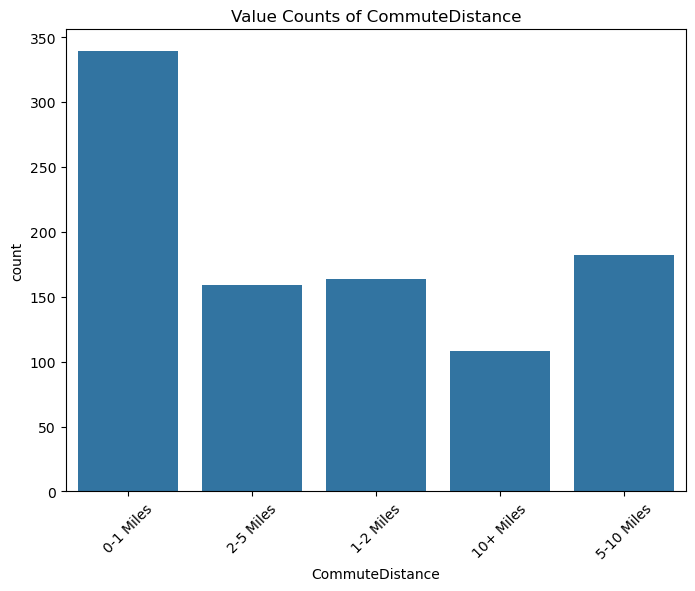

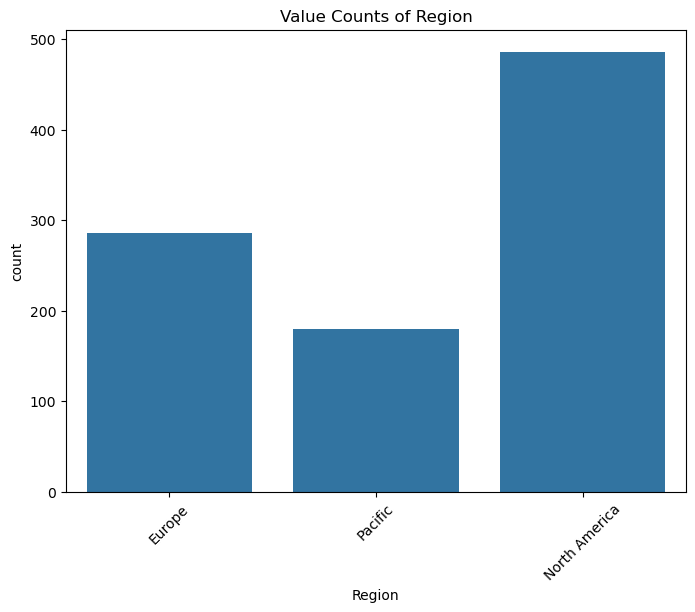

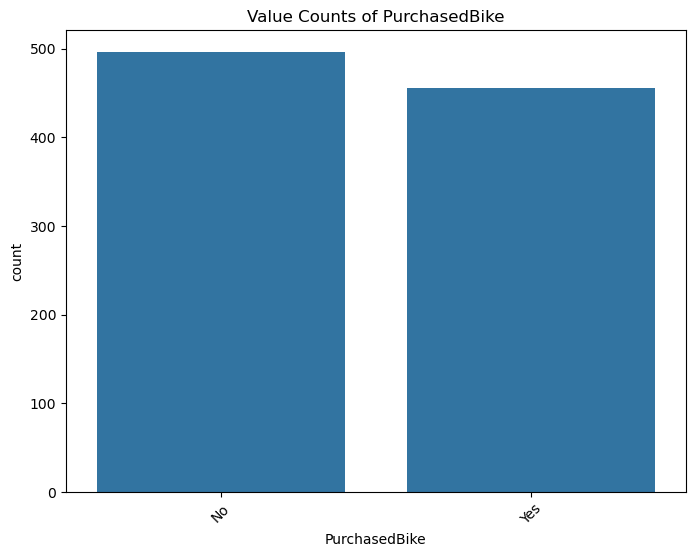

In [10]:
get_count_plots(df, cols_list)

From the categorical we can see there are sligtly less purchases than non-purchasing cutomers. North America , homeownership, and married married status have the highest counts of their categories. These categorical datacounts can help stakeholders and analysts evaluate statistics on their customers.

##### Relational features

<AxesSubplot:>

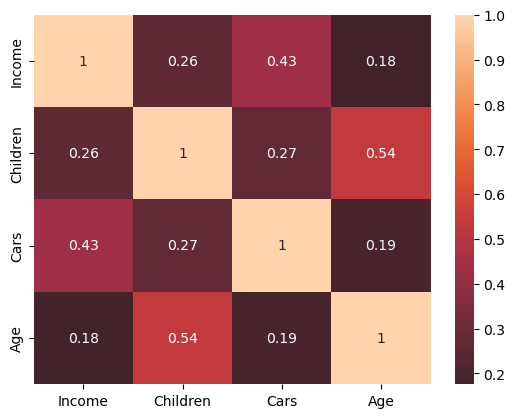

In [11]:
data= df[['Income','Children','Cars','Age']]

#use correlation matrix and heatmap to identify relational features
cmatrix= data.corr()
sns.heatmap(cmatrix,annot=True, center=0)

The heatmap above shows correlation between continuos variables in our dataset. Children and age are the most correlated in our dataset, but do little to tell us about whether or not a cutomer will purchase a bike.

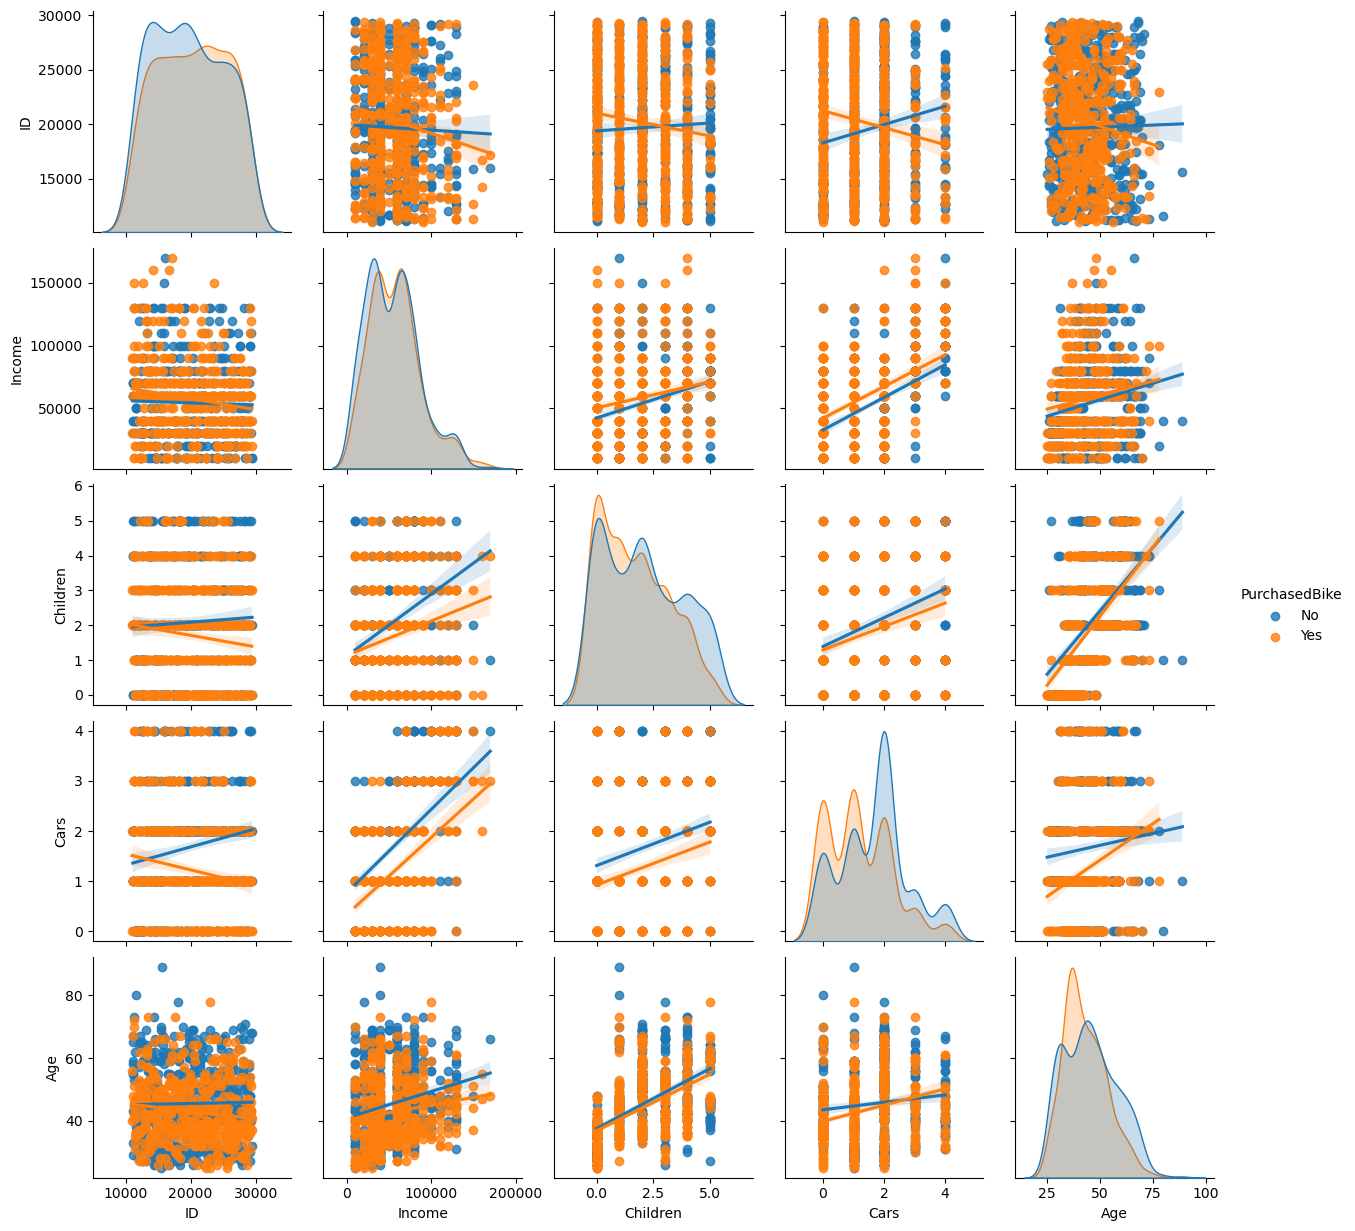

In [12]:
#pairplot 
sns.pairplot(data = df, 
             kind='reg',hue='PurchasedBike',corner=False)

The pair plot above is colored to show those who purchsed a bike in orange, and those who did not in blue. This plot is more valuable in determining features that affect purchasing status. Looking at the pair plot above children and cars may have a negative correlation with bike purchases compared to not purchasing. The rest of the features are correlated with both purchase statuses, with the exception of age.

<AxesSubplot:xlabel='PurchasedBike', ylabel='Cars'>

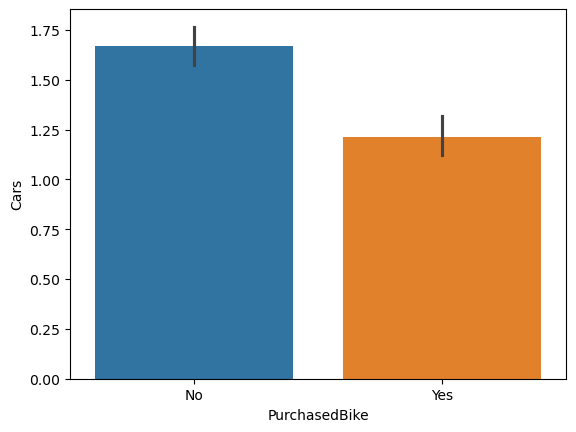

In [13]:
#plot means of number of cars by purchasing status
sns.barplot(data = df,x='PurchasedBike',y='Cars', hue='PurchasedBike')

<AxesSubplot:xlabel='PurchasedBike', ylabel='Cars'>

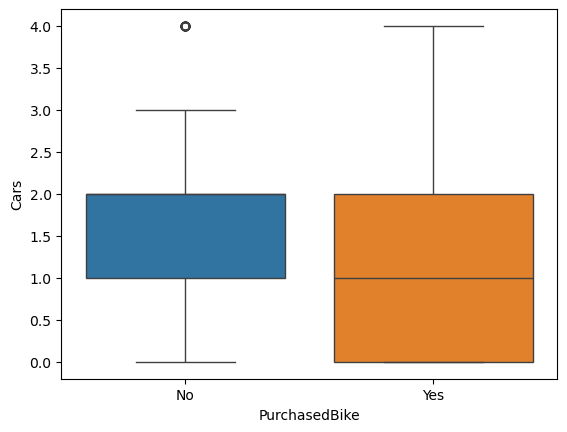

In [14]:
#plot means of number of cars by purchasing status
sns.boxplot(data = df,x='PurchasedBike',y='Cars', hue='PurchasedBike')

<AxesSubplot:xlabel='PurchasedBike', ylabel='Children'>

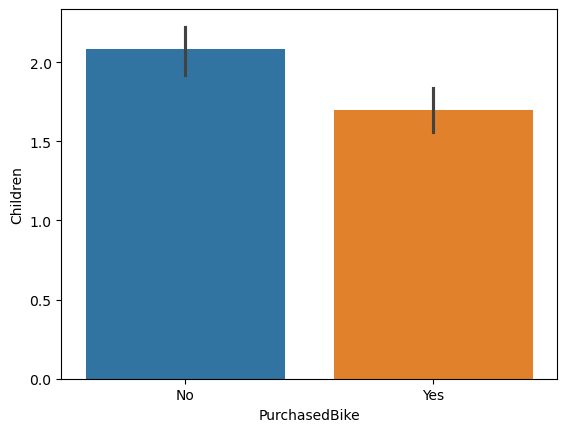

In [15]:
#plot means of number of cars by purchasing status
sns.barplot(data = df,x='PurchasedBike',y='Children', hue='PurchasedBike')

<AxesSubplot:xlabel='PurchasedBike', ylabel='Children'>

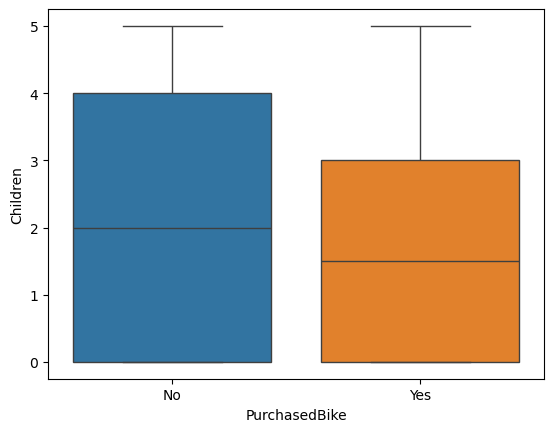

In [16]:
#plot means of number of children by purchasing status
sns.boxplot(data = df,x='PurchasedBike',y='Children', hue='PurchasedBike')

The plots above continue to show the relationeen a higher mean of cars and children and not purchasing bikes. There is one outlier in the cars and bikes not purchased category. We can remove this

In [17]:
#remove outliers grouped by Purchased Bike
#calculate quantiles for each group
low = 0.05
high = 0.95
res = df.groupby('PurchasedBike')['Cars'].quantile([low, high]).unstack(level=1)

# Filter rows within the quantile range
df = df[((res.loc[df['PurchasedBike'], low] < df['Cars'].values) &
                  (df['Cars'].values < res.loc[df['PurchasedBike'],
                                                  high])).values]

In [18]:
#remove outliers grouped by Purchased Bike
#calculate quantiles for each group
low = 0.05
high = 0.95
res = df.groupby('PurchasedBike')['Children'].quantile([low, high]).unstack(level=1)

# Filter rows within the quantile range
df = df[((res.loc[df['PurchasedBike'], low] < df['Children'].values) &
                  (df['Children'].values < res.loc[df['PurchasedBike'],
                                                  high])).values]

##### Test Assumptions

In [20]:
#create arrays of cars by purchase made
car_np= df['Cars'].loc[df['PurchasedBike']=='No']
car_p= df['Cars'].loc[df['PurchasedBike']=='Yes']

#create arrays of cars by children
child_np= df['Children'].loc[df['PurchasedBike']=='No']
child_p= df['Children'].loc[df['PurchasedBike']=='Yes']

In [21]:
#run stats levene to assess equal variance between cars
stats.levene(car_np, car_p)

LeveneResult(statistic=0.17409475725747775, pvalue=0.6767406621763621)

In [22]:
#run stats levene to assess equal variance between children
stats.levene(child_np, child_p)

LeveneResult(statistic=13.070230122320009, pvalue=0.0003417014727069214)

In [36]:
#dummy encode purchsed bike to allow for regression
df.PurchasedBike.replace(to_replace=['No', 'Yes'], value=[0, 1],
                         inplace=True)

In [37]:
df['PurchasedBike'].astype(int)

1      0
10     1
13     1
14     1
15     1
      ..
987    0
989    0
995    1
998    0
999    1
Name: PurchasedBike, Length: 371, dtype: int32

In [40]:
#create model
model =ols ("PurchasedBike ~ Cars + Children", data=df).fit()

#use shapiro test to test assumption of normality
stats.shapiro(model.resid)

ShapiroResult(statistic=0.9218282103538513, pvalue=5.498368687434363e-13)

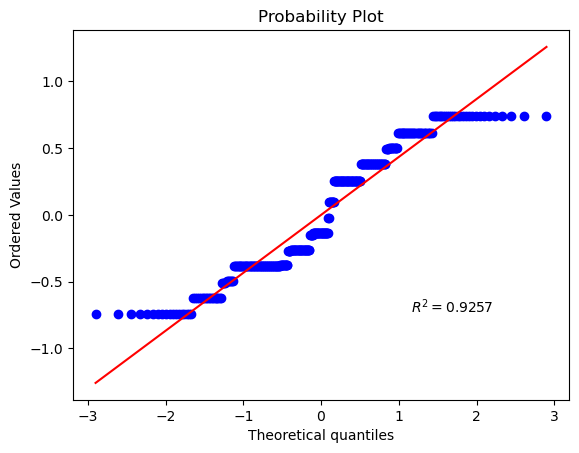

In [41]:
#Create QQplot to visualize normality in the dataset
normality_plot, stat = stats.probplot(model.resid,plot=plt, rvalue= True)

In [39]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          PurchasedBike   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     41.15
Date:                Tue, 09 Apr 2024   Prob (F-statistic):           7.42e-17
Time:                        21:23:38   Log-Likelihood:                -228.56
No. Observations:                 371   AIC:                             463.1
Df Residuals:                     368   BIC:                             474.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1042      0.078     14.236      0.000       0.952       1.257
Cars          -0.2365      0.042     -5.574      0.000      -0.320      -0.153
Children      -0.1231      0.026     -4.680      0.000      -0.175      -0.071
==============================================================================
Omnibus:                      396.786   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.673
Skew:                           0.148   Prob(JB):                     1.61e-06
Kurtosis:                       1.720   Cond. No.                         11.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The assumption testing for Anova testing was ran above. The levene statistic was ran to asses equal variance on the Cars and Children features. The null hypothesis was accepted on the Cars feature, but slightly below the threshold on the Children feature. Anova testing is pretty resistent to unequal variance, and a slight difference should not have a large impact on the model. Shapiro statistic and a QQ plot were ran to asses the assumption of normality and failed. We can use a non-parametric Anova model to account for this. The Durbin-Watson statistic shows that the features are independent from each other. 

##### ANOVA Testing

In [46]:
# Compute the Kruskal-Wallis test
kruskal(car_np, car_p, child_np, child_p)

KruskalResult(statistic=160.4051179457113, pvalue=1.4986595505414022e-34)

The p-value from the Kruskal Wallis test is below the threshold of 0.05, indicating there is a statistically significant difference in means of the dataset.

In [49]:
# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=df[['Cars']],
                          groups=df['PurchasedBike'],
                          alpha=0.05)

#display results
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1  -0.4358   0.0 -0.5492 -0.3225   True
---------------------------------------------------


In [50]:
# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=df[['Children']],
                          groups=df['PurchasedBike'],
                          alpha=0.05)

#display results
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1  -0.6474   0.0 -0.8324 -0.4625   True
---------------------------------------------------


Tukeys testing shows us that the means are statistically significant across all groups.

##### Regression Testing

In [68]:
#define X features
X = df[['Cars','Children']]
y = df['PurchasedBike']

# Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform data scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create regression linear model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train_scaled, y_train)

# Income prediction using test data
y_pred = model.predict(X_test_scaled)

# Model evaluation using Mean Squared Error (MSE) and R-squared metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared: {r2}')
print('Koefisien Regresi:', model.coef_)
print('Konstanta Regresi:', model.intercept_)

Mean Squared Error (MSE): 0.2131572046102666
R-squared: 0.0888987264948713
Koefisien Regresi: [-0.1477288  -0.12249728]
Konstanta Regresi: 0.44932432432432434


The above model performed poorly, let's try methods to improve it.

In [72]:
#define X features
X = df[['Cars', 'Age', 'Income', 'Children']]
y = df['PurchasedBike']

# Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform data scaling
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create regression linear model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train_scaled, y_train)

# Income prediction using test data
y_pred = model.predict(X_test_scaled)

# Model evaluation using Mean Squared Error (MSE) and R-squared metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared: {r2}')
print('Koefisien Regresi:', model.coef_)
print('Konstanta Regresi:', model.intercept_)

Mean Squared Error (MSE): 0.21191967464909456
R-squared: 0.09418832074380201
Koefisien Regresi: [-0.14164288 -0.03713258  0.01581195 -0.11822172]
Konstanta Regresi: 0.44932432432432434


Adding more fetures to the model did not make a significant improvement on the model. So although we answered the hypothesis of numbers of cars and children having a significant difference in mean bike purchases, we could not further explore or validate this in our regression. For the feature being predicted on, a logistic regression model should have a better fit for a binomial data feature like we have here. Logistic regression goes beyond what was covered in this course, but this can be explored in future courses. 

As for linear regression, another possible application on this dataset would be customer segmentation. This would allow the merchant to expand their knowledge of their customer base and target a specific feature or type of cutomer. 

In [76]:
#define X features
X = df[['Income', 'Age', 'Cars']]
y = df['Children']

# Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform data scaling
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create regression linear model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train_scaled, y_train)

# Income prediction using test data
y_pred = model.predict(X_test_scaled)

# Model evaluation using Mean Squared Error (MSE) and R-squared metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared: {r2}')
print('Koefisien Regresi:', model.coef_)
print('Konstanta Regresi:', model.intercept_)

Mean Squared Error (MSE): 0.841052050557147
R-squared: 0.1475823811920809
Koefisien Regresi: [0.1027192  0.14799942 0.26294624]
Konstanta Regresi: 2.3074324324324325


In this regression model, we were able to successfully create a prediction for customers who have children. Stake holders could use this model to target areas where features predict lower amount of children, since a lower mean children was associated with purchasing a bike. On the other hand, the stakeholders could use this as knowledge for tapping into an underserved market by offering more bikes for children or wagons in which parents can bike their kids. 